Compare completeness between enigma_1189 (our new baseline) with and without NES observations, and completeness for opsim4_152 (a 12 year run, 'optimized' for NEOs because it's longer). 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd

In [3]:
orbitfile = 'pha20141031.des'
outroot = orbitfile.replace('.des', '').replace('.txt', '')

orbits = pd.read_table(orbitfile, sep='\s*', engine='python')
orbits = orbits.to_records()

In [5]:
# Read observations files from the various runs.
obsfile = 'enigma_1189/' + outroot + '_allObs.txt'
enigmaobs = pd.read_table(obsfile, sep='\s*', engine='python')
enigmaobs = enigmaobs.to_records()

In [6]:
obsfile = 'opsim4_152/' + outroot + '_allObs.txt'
opsim4152obs = pd.read_table(obsfile, sep='\s*', engine='python')
opsim4152obs = opsim4152obs.to_records()

In [22]:
obsfile = 'opsim3_61/' + outroot + '_allObs.txt'
opsim361obs = pd.read_table(obsfile, sep='\s*', engine='python')
opsim361obs = opsim361obs.to_records()

In [7]:
def DiscoveryMetric(ssoObs, magH=20., Hrange=np.arange(13, 27, 0.25), snrLimit=5, 
                    nObsPerNight=2, nNightsPerWindow=3, window=15):
    # Given the observations for a particular object and the opsim metadata (join using joinObs)
    # Return the number possibilities for 'discovery' of the object, as a function of H
    discoveryChances = np.zeros(len(Hrange), int)
    if len(ssoObs) == 0:
        return discoveryChances
    # Calculate the magnitude of this object in this filter, each H magnitude. 
    for i, H in enumerate(Hrange):
        magObs = H - magH + ssoObs['magV'] + ssoObs['dmagColor']
        magLimitWithTrailing = ssoObs['fiveSigmaDepth'] - ssoObs['dmagTrailing']
        snr = 5.0 * np.power(10., 0.4*(magLimitWithTrailing - magObs))
        vis = np.where(snr>=snrLimit)[0]
        # more complicated function for visibility
        if len(vis) == 0:
            discoveryChances[i] = 0
        else:
            # Now to identify where observations meet the timing requirements.
            #  Identify visits where the 'night' changes. 
            nights = np.sort(ssoObs['night'][vis])
            nightChangeIdx = np.where(nights != np.roll(nights, 1))[0]
            # NightChangeIdx now points at all the nights where the night is different than the previous. 
            # Look at difference in index values: difference is number of obs that were within each night.
            #   if difference is > nObsPerNight, this is a 'good' night. Subtract 1 to point at proper night.
            moreThanXIdx = np.where(nightChangeIdx - np.roll(nightChangeIdx, 1) >= 2)[0] - 1
            # Set moreThanXIdx to be the actual values of the night array where there were more than nObsPerNight.
            moreThanXIdx = nightChangeIdx[moreThanXIdx]
            # Identify actual night values, to look at 'window' interval.
            nightsX = nights[moreThanXIdx]
            # Look at intervals between 'good' nights. 
            if len(nightsX) < nNightsPerWindow:
                discoveryChances[i] = 0
            else:
                nw = nNightsPerWindow - 1
                windowIdx = np.concatenate([np.where(nightsX[nw:2*nw] - nightsX[:nw] <= window)[0],
                                           np.where(nightsX[nw:] - nightsX[:-nw] <= window)[0],
                                           np.where(nightsX[-nw:] - nightsX[-2*nw:-nw] <= window)[0] + len(nightsX)-1-nw])
                windowIdx = np.unique(windowIdx)
                discoveryChances[i] = windowIdx.size
                #print nightsX[windowIdx]
    return discoveryChances

In [9]:
def Completeness(discoveryChances, Hrange, numSsos, requiredChances=1):
    completeness = np.zeros(len(Hrange), float)
    discoveries = discoveryChances.swapaxes(0, 1)
    for i, H in enumerate(Hrange):
        completeness[i] = np.where(discoveries[i] >= requiredChances)[0].size
    completeness = completeness/float(numSsos)
    return completeness

In [11]:
def integrateH(summaryVals, Hrange, Hindex=0.3):
    # Set expected H distribution. 
    # dndh = differential size distribution (number in this bin)
    dndh = np.power(10., Hindex*(Hrange-Hrange.min()))
    # dn = cumulative size distribution (number in this bin and brighter)
    dn = np.cumsum(dndh)
    intVals = np.cumsum(summaryVals*dndh)/dn
    return intVals

Set up some plotting routines.

In [12]:
def metricVsH(metricVals, Hrange, npmethod=np.mean, label='Mean', fignum=None):
    fig = plt.figure(fignum)
    if npmethod is not None:
        vals = npmethod(metricVals, axis=0)
    else:
        vals = metricVals
    plt.plot(Hrange, vals, label=label)
    plt.xlabel('H (mag)')
    return fig.number

In [13]:
def metricVs2dOrbits(x, y, xlabel, ylabel, 
                     metricVals, units, Hval, Hrange,
                     xbins, ybins):
    xvals = x
    yvals = y
    nxbins = len(xbins)
    nybins = len(ybins)
    xbinsize = np.mean(np.diff(xbins))
    ybinsize = np.mean(np.diff(ybins))
    xmin = np.min(xbins)
    ymin = np.min(ybins)
    # Set up to calculate summary values at each x/y binpoint. 
    summaryVals = np.zeros((nybins, nxbins), dtype='float')
    summaryNums = np.zeros((nybins, nxbins), dtype='int')
    Hidx = np.where(Hrange == Hval)[0]
    # Metrics are evaluated in the order of the orbits. 
    for i, (xi, yi) in enumerate(zip(x, y)):
        xidx = np.min([int((xi - xmin)/xbinsize), nxbins-1])
        yidx = np.min([int((yi - ymin)/ybinsize), nybins-1])
        summaryVals[yidx][xidx] += metricVals[i][Hidx]
        summaryNums[yidx][xidx] += 1
    summaryVals = np.where(summaryNums != 0, summaryVals / summaryNums, 0)
    # Create 2D x/y arrays, to match 2D counts array.
    xi, yi = np.meshgrid(xbins, ybins)
    # Plot. 
    plt.figure()
    levels = np.arange(summaryVals.min(), summaryVals.max(), (summaryVals.max() - summaryVals.min())/200.0)
    levels = np.arange(0, 30, 1)
    plt.contourf(xi, yi, summaryVals, levels, extend='max', zorder=0)
    #plt.plot(orbits[xlabel], orbits[ylabel], 'k.', markersize=2, zorder=3)
    cbar = plt.colorbar()
    cbar.set_label(units)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

In [14]:
from matplotlib.patches import Ellipse
from matplotlib.collections import PatchCollection

def metricVs2dOrbitsPoints(orbits, xlabel, ylabel, metricVals, Hval, Hrange, 
                           foregroundPoints=True, backgroundPoints=True):
    x = orbits[xlabel]
    y = orbits[ylabel]    
    Hidx = np.where(Hrange == Hval)[0]
    plt.figure()
    colors = np.swapaxes(metricVals, 0, 1)[Hidx][0]
    vmin = np.max(1, colors.min())
    if backgroundPoints:
        condition = np.where(colors == 0)
        plt.plot(x[condition], y[condition], 'r.', markersize=4, alpha=0.5, zorder=3)
    if foregroundPoints:
        plt.scatter(x, y, c=colors, vmin=vmin, s=15, alpha=0.8, zorder=0)
        cb = plt.colorbar()
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

Run metric and make plots.

In [15]:
ssoID = '!!ObjID'
ssoID_orbit = ssoID
if ssoID_orbit not in orbits.dtype.names:
    ssoID_orbit = '!!OID'

ssoids = orbits[ssoID_orbit]
if len(ssoids) != len(np.unique(orbits[ssoID_orbit])):
    print "Orbit id's are repeated!"

Completeness at H<=22 with alpha=0.3 = 70.6% (15 night window), requiring 1 chances
Completeness at H<=22 with alpha=0.4 = 67.3% (15 night window), requiring 1 chances
Completeness at H<=22 with alpha=0.5 = 64.9% (15 night window), requiring 1 chances
Completeness at H<=22 with alpha=0.3 = 67.2% (15 night window), requiring 2 chances
Completeness at H<=22 with alpha=0.4 = 63.6% (15 night window), requiring 2 chances
Completeness at H<=22 with alpha=0.5 = 61.0% (15 night window), requiring 2 chances
Completeness at H<=22 with alpha=0.3 = 61.8% (15 night window), requiring 3 chances
Completeness at H<=22 with alpha=0.4 = 57.8% (15 night window), requiring 3 chances
Completeness at H<=22 with alpha=0.5 = 54.9% (15 night window), requiring 3 chances
Completeness at H<=22 with alpha=0.3 = 73.5% (30 night window), requiring 1 chances
Completeness at H<=22 with alpha=0.4 = 70.4% (30 night window), requiring 1 chances
Completeness at H<=22 with alpha=0.5 = 68.1% (30 night window), requiring 1 

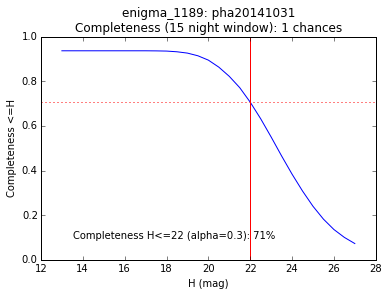

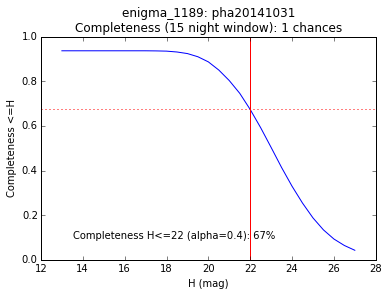

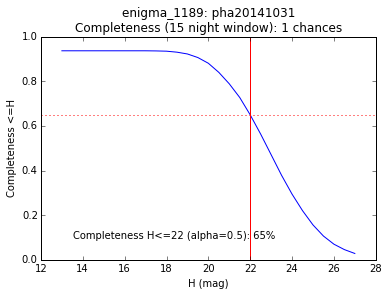

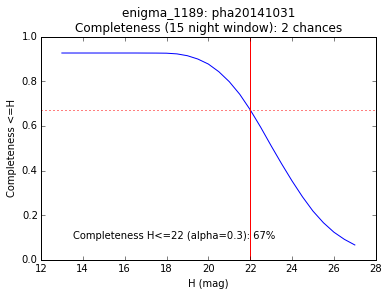

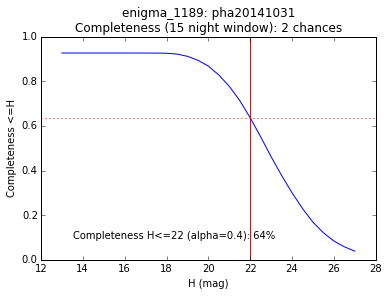

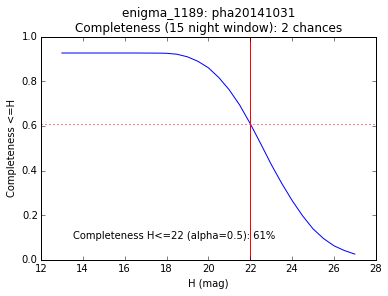

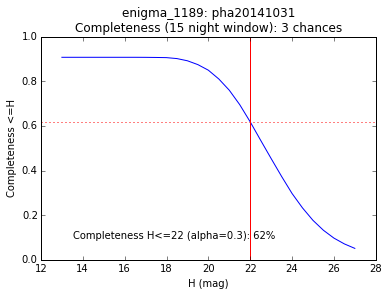

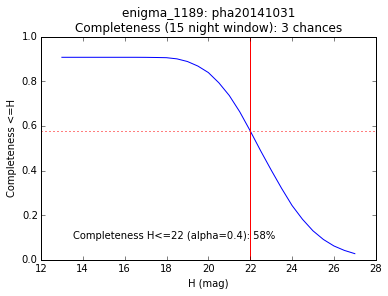

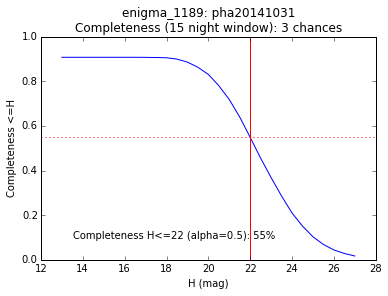

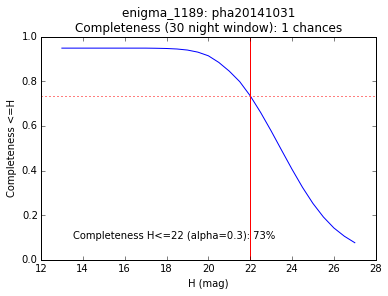

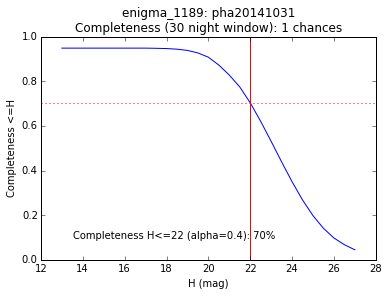

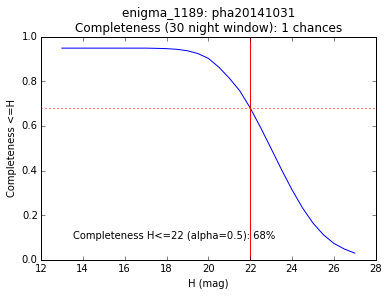

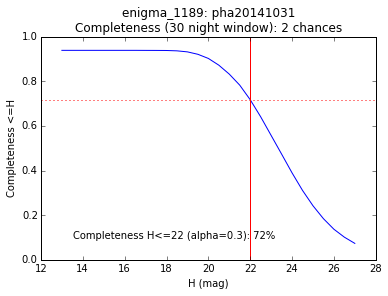

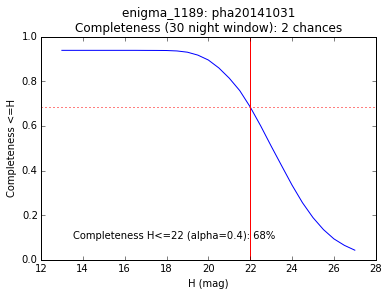

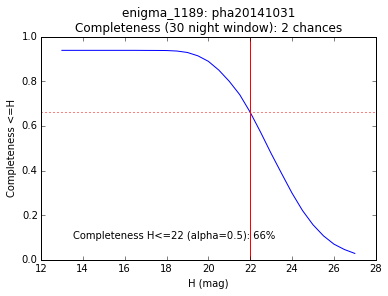

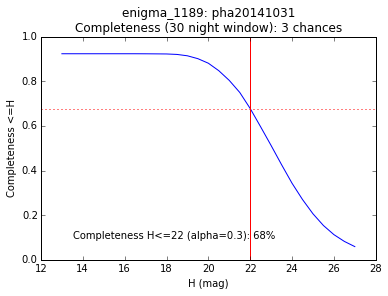

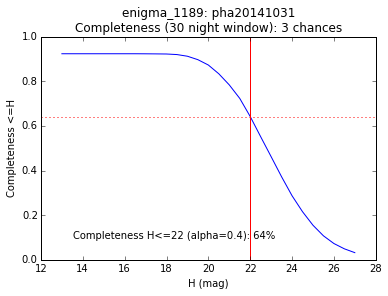

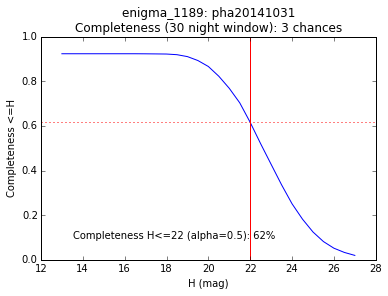

In [19]:
obs = enigmaobs
opsim = 'enigma_1189'

# Set up to run metrics over wider range of H.
Hrange = np.arange(13, 27.2, 0.5)
sNum = float(len(ssoids))

discoveries = np.zeros([len(ssoids), len(Hrange)], int)
discoveries30 = np.zeros([len(ssoids), len(Hrange)], int)
completeness = np.zeros([len(ssoids), len(Hrange)], int)

# Run Metrics.
for i, sso in enumerate(ssoids):
    ssoObs = obs[np.where(obs[ssoID] == sso)]
    orbit = orbits[np.where(orbits[ssoID_orbit] == sso)]
    discoveries[i] = DiscoveryMetric(ssoObs, Hrange=Hrange, window=15)
    discoveries30[i] = DiscoveryMetric(ssoObs, Hrange=Hrange, window=30)

completeness = Completeness(discoveries, Hrange, sNum)
completeness30 = Completeness(discoveries30, Hrange, sNum)

completeness_2 = Completeness(discoveries, Hrange, sNum, requiredChances=2)
completeness30_2 = Completeness(discoveries30, Hrange, sNum, requiredChances=2)

completeness_3 = Completeness(discoveries, Hrange, sNum, requiredChances=3)
completeness30_3 = Completeness(discoveries30, Hrange, sNum, requiredChances=3)

for i, c in enumerate([completeness, completeness_2, completeness_3]):
    for alpha in [0.3, 0.4, 0.5]:
        compH = integrateH(c, Hrange, Hindex=alpha)
        fignum = metricVsH(compH, Hrange, None)
        plt.ylabel('Completeness <=H')
        plt.title('%s: %s\n%s' %(opsim, outroot, 'Completeness (15 night window): %d chances' %(i+1)))
        #completeness at H<=22
        Hidx = np.where(Hrange==22.0)[0]
        comp22 = compH[Hidx]
        plt.axhline(comp22, color='r', linestyle=':')
        plt.axvline(22, color='r')
        plt.figtext(0.2, 0.2, 'Completeness H<=22 (alpha=%.1f): %.0f%s' %(alpha, comp22*100, '%'))
        print "Completeness at H<=22 with alpha=%.1f = %.1f%s (15 night window), requiring %d chances"  %(alpha, 
                                                                                            comp22*100, 
                                                                                            '%', i+1)

for i, c in enumerate([completeness30, completeness30_2, completeness30_3]):
    for alpha in [0.3, 0.4, 0.5]:
        compH = integrateH(c, Hrange, Hindex=alpha)
        fignum = metricVsH(compH, Hrange, None)
        plt.ylabel('Completeness <=H')
        plt.title('%s: %s\n%s' %(opsim, outroot, 'Completeness (30 night window): %d chances' %(i+1)))
        #completeness at H<=22
        Hidx = np.where(Hrange==22.0)[0]
        comp22 = compH[Hidx]
        plt.axhline(comp22, color='r', linestyle=':')
        plt.axvline(22, color='r')
        plt.figtext(0.2, 0.2, 'Completeness H<=22 (alpha=%.1f): %.0f%s' %(alpha, comp22*100, '%'))
        print "Completeness at H<=22 with alpha=%.1f = %.1f%s (30 night window), requiring %d chances"  %(alpha, 
                                                                                            comp22*100, 
                                                                                            '%', i+1)

Completeness at H<=22 with alpha=0.3 = 67.3% (15 night window), requiring 1 chances
Completeness at H<=22 with alpha=0.4 = 63.5% (15 night window), requiring 1 chances
Completeness at H<=22 with alpha=0.5 = 60.8% (15 night window), requiring 1 chances
Completeness at H<=22 with alpha=0.3 = 63.6% (15 night window), requiring 2 chances
Completeness at H<=22 with alpha=0.4 = 59.6% (15 night window), requiring 2 chances
Completeness at H<=22 with alpha=0.5 = 56.7% (15 night window), requiring 2 chances
Completeness at H<=22 with alpha=0.3 = 58.5% (15 night window), requiring 3 chances
Completeness at H<=22 with alpha=0.4 = 54.1% (15 night window), requiring 3 chances
Completeness at H<=22 with alpha=0.5 = 51.0% (15 night window), requiring 3 chances
Completeness at H<=22 with alpha=0.3 = 69.5% (30 night window), requiring 1 chances
Completeness at H<=22 with alpha=0.4 = 65.9% (30 night window), requiring 1 chances
Completeness at H<=22 with alpha=0.5 = 63.3% (30 night window), requiring 1 

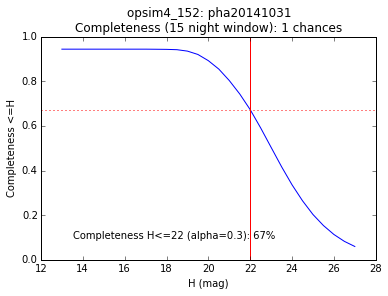

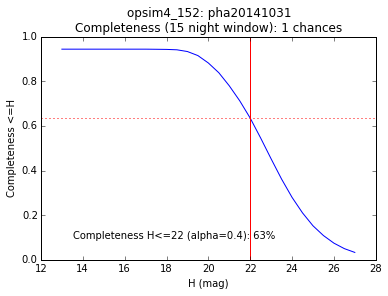

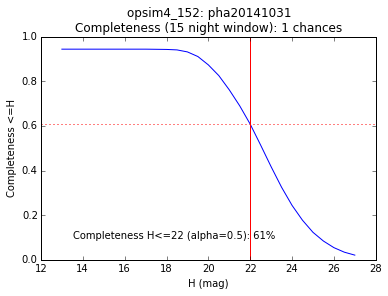

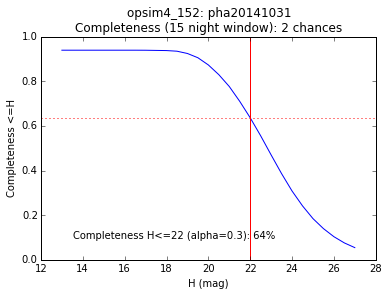

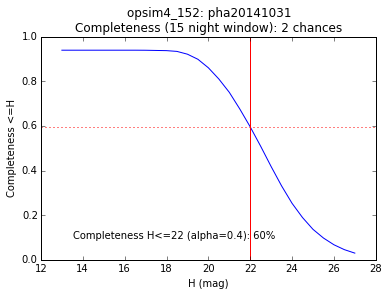

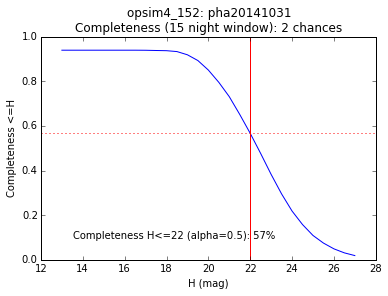

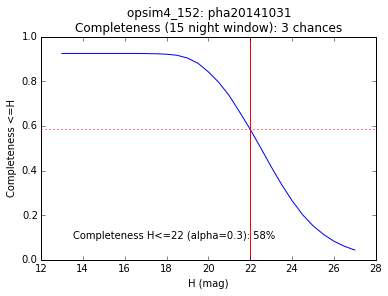

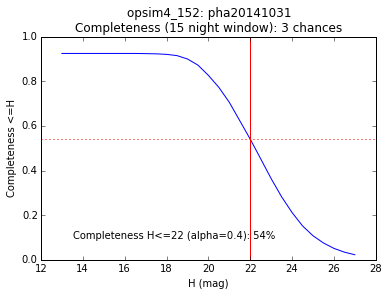

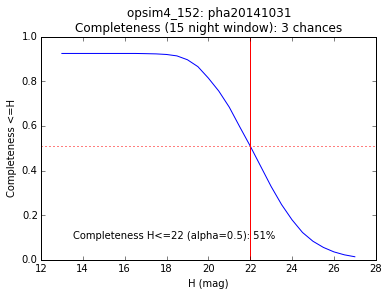

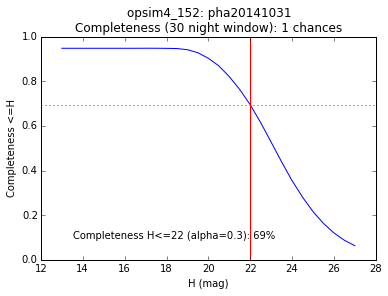

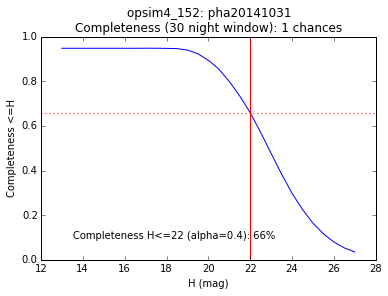

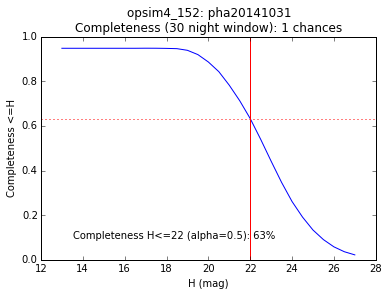

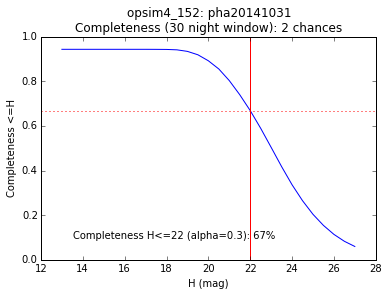

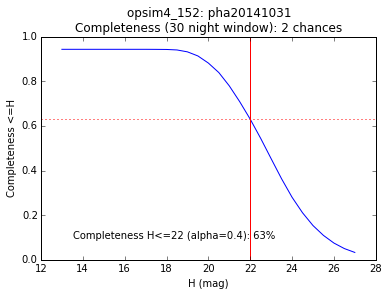

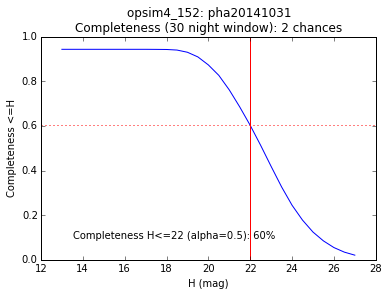

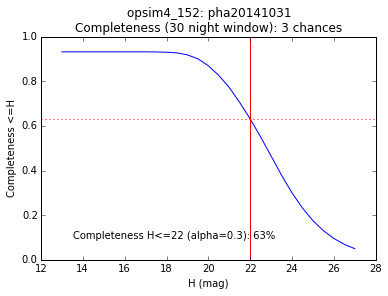

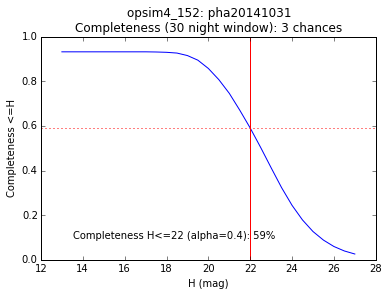

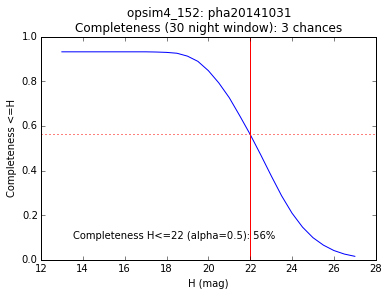

In [20]:
obs = opsim4152obs
opsim = 'opsim4_152'

# Set up to run metrics over wider range of H.
Hrange = np.arange(13, 27.2, 0.5)
sNum = float(len(ssoids))

discoveries = np.zeros([len(ssoids), len(Hrange)], int)
discoveries30 = np.zeros([len(ssoids), len(Hrange)], int)
completeness = np.zeros([len(ssoids), len(Hrange)], int)

# Run Metrics.
for i, sso in enumerate(ssoids):
    ssoObs = obs[np.where(obs[ssoID] == sso)]
    orbit = orbits[np.where(orbits[ssoID_orbit] == sso)]
    discoveries[i] = DiscoveryMetric(ssoObs, Hrange=Hrange, window=15)
    discoveries30[i] = DiscoveryMetric(ssoObs, Hrange=Hrange, window=30)

completeness = Completeness(discoveries, Hrange, sNum)
completeness30 = Completeness(discoveries30, Hrange, sNum)

completeness_2 = Completeness(discoveries, Hrange, sNum, requiredChances=2)
completeness30_2 = Completeness(discoveries30, Hrange, sNum, requiredChances=2)

completeness_3 = Completeness(discoveries, Hrange, sNum, requiredChances=3)
completeness30_3 = Completeness(discoveries30, Hrange, sNum, requiredChances=3)

for i, c in enumerate([completeness, completeness_2, completeness_3]):
    for alpha in [0.3, 0.4, 0.5]:
        compH = integrateH(c, Hrange, Hindex=alpha)
        fignum = metricVsH(compH, Hrange, None)
        plt.ylabel('Completeness <=H')
        plt.title('%s: %s\n%s' %(opsim, outroot, 'Completeness (15 night window): %d chances' %(i+1)))
        #completeness at H<=22
        Hidx = np.where(Hrange==22.0)[0]
        comp22 = compH[Hidx]
        plt.axhline(comp22, color='r', linestyle=':')
        plt.axvline(22, color='r')
        plt.figtext(0.2, 0.2, 'Completeness H<=22 (alpha=%.1f): %.0f%s' %(alpha, comp22*100, '%'))
        print "Completeness at H<=22 with alpha=%.1f = %.1f%s (15 night window), requiring %d chances"  %(alpha, 
                                                                                            comp22*100, 
                                                                                            '%', i+1)

for i, c in enumerate([completeness30, completeness30_2, completeness30_3]):
    for alpha in [0.3, 0.4, 0.5]:
        compH = integrateH(c, Hrange, Hindex=alpha)
        fignum = metricVsH(compH, Hrange, None)
        plt.ylabel('Completeness <=H')
        plt.title('%s: %s\n%s' %(opsim, outroot, 'Completeness (30 night window): %d chances' %(i+1)))
        #completeness at H<=22
        Hidx = np.where(Hrange==22.0)[0]
        comp22 = compH[Hidx]
        plt.axhline(comp22, color='r', linestyle=':')
        plt.axvline(22, color='r')
        plt.figtext(0.2, 0.2, 'Completeness H<=22 (alpha=%.1f): %.0f%s' %(alpha, comp22*100, '%'))
        print "Completeness at H<=22 with alpha=%.1f = %.1f%s (30 night window), requiring %d chances"  %(alpha, 
                                                                                            comp22*100, 
                                                                                            '%', i+1)

Completeness at H<=22 with alpha=0.3 = 64.1% (15 night window), requiring 1 chances
Completeness at H<=22 with alpha=0.4 = 61.0% (15 night window), requiring 1 chances
Completeness at H<=22 with alpha=0.5 = 58.8% (15 night window), requiring 1 chances
Completeness at H<=22 with alpha=0.3 = 60.3% (15 night window), requiring 2 chances
Completeness at H<=22 with alpha=0.4 = 57.0% (15 night window), requiring 2 chances
Completeness at H<=22 with alpha=0.5 = 54.7% (15 night window), requiring 2 chances
Completeness at H<=22 with alpha=0.3 = 54.5% (15 night window), requiring 3 chances
Completeness at H<=22 with alpha=0.4 = 50.9% (15 night window), requiring 3 chances
Completeness at H<=22 with alpha=0.5 = 48.3% (15 night window), requiring 3 chances
Completeness at H<=22 with alpha=0.3 = 67.0% (30 night window), requiring 1 chances
Completeness at H<=22 with alpha=0.4 = 64.1% (30 night window), requiring 1 chances
Completeness at H<=22 with alpha=0.5 = 61.9% (30 night window), requiring 1 

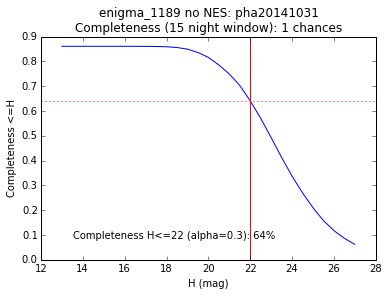

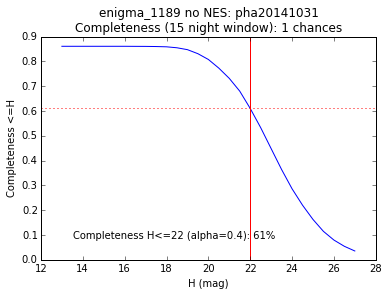

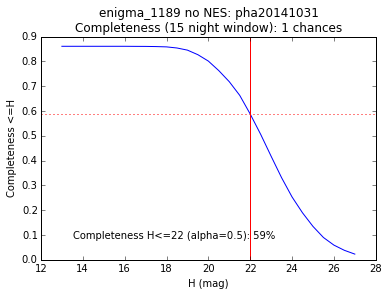

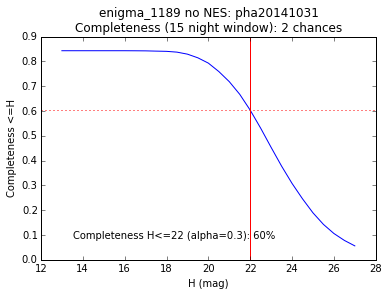

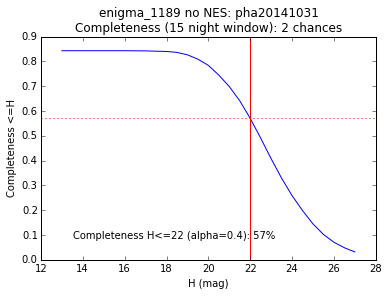

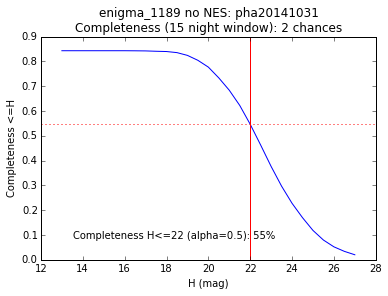

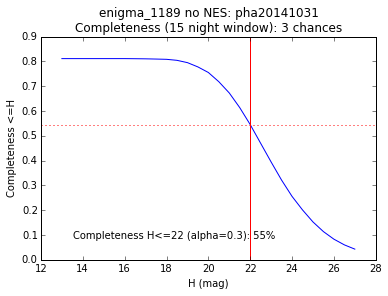

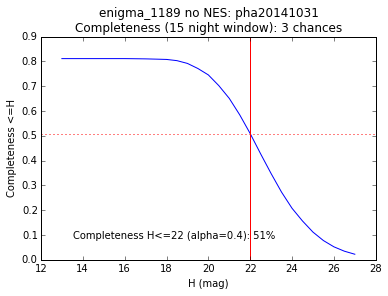

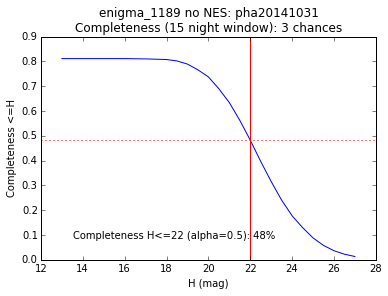

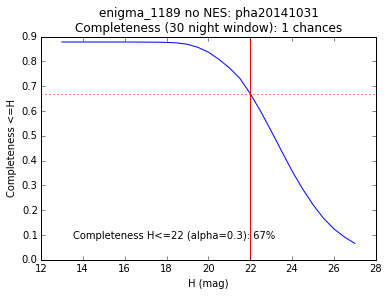

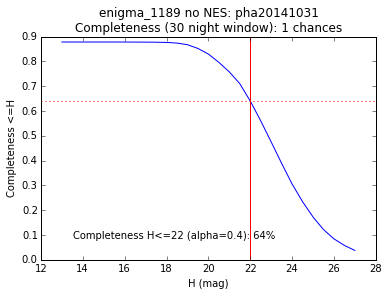

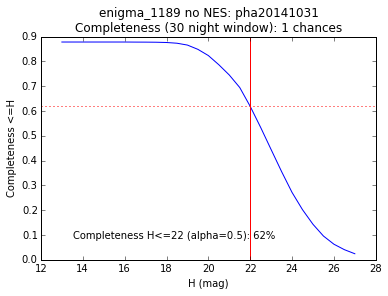

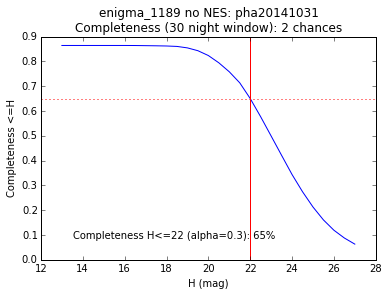

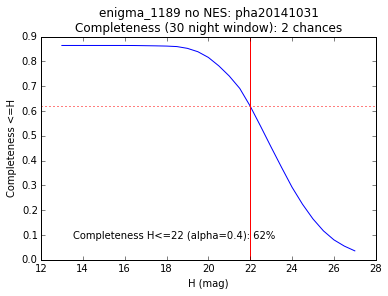

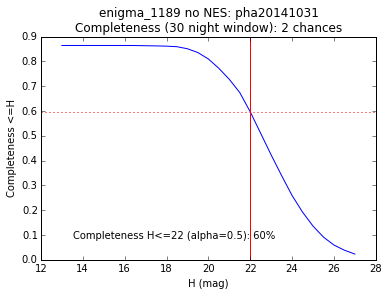

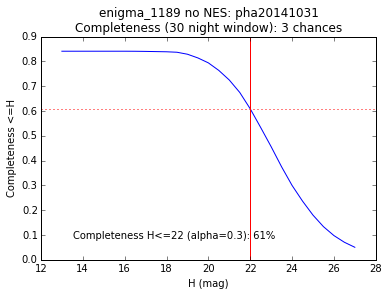

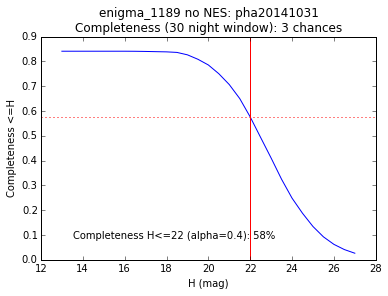

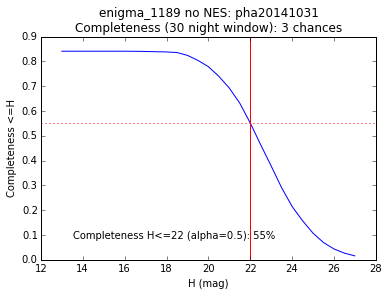

In [21]:
condition = np.where(enigmaobs['dec'] < 0.046916) # exclude the NES
obs = enigmaobs[condition]
opsim = 'enigma_1189 no NES'

# Set up to run metrics over wider range of H.
Hrange = np.arange(13, 27.2, 0.5)
sNum = float(len(ssoids))

discoveries = np.zeros([len(ssoids), len(Hrange)], int)
discoveries30 = np.zeros([len(ssoids), len(Hrange)], int)
completeness = np.zeros([len(ssoids), len(Hrange)], int)

# Run Metrics.
for i, sso in enumerate(ssoids):
    ssoObs = obs[np.where(obs[ssoID] == sso)]
    orbit = orbits[np.where(orbits[ssoID_orbit] == sso)]
    discoveries[i] = DiscoveryMetric(ssoObs, Hrange=Hrange, window=15)
    discoveries30[i] = DiscoveryMetric(ssoObs, Hrange=Hrange, window=30)

completeness = Completeness(discoveries, Hrange, sNum)
completeness30 = Completeness(discoveries30, Hrange, sNum)

completeness_2 = Completeness(discoveries, Hrange, sNum, requiredChances=2)
completeness30_2 = Completeness(discoveries30, Hrange, sNum, requiredChances=2)

completeness_3 = Completeness(discoveries, Hrange, sNum, requiredChances=3)
completeness30_3 = Completeness(discoveries30, Hrange, sNum, requiredChances=3)

for i, c in enumerate([completeness, completeness_2, completeness_3]):
    for alpha in [0.3, 0.4, 0.5]:
        compH = integrateH(c, Hrange, Hindex=alpha)
        fignum = metricVsH(compH, Hrange, None)
        plt.ylabel('Completeness <=H')
        plt.title('%s: %s\n%s' %(opsim, outroot, 'Completeness (15 night window): %d chances' %(i+1)))
        #completeness at H<=22
        Hidx = np.where(Hrange==22.0)[0]
        comp22 = compH[Hidx]
        plt.axhline(comp22, color='r', linestyle=':')
        plt.axvline(22, color='r')
        plt.figtext(0.2, 0.2, 'Completeness H<=22 (alpha=%.1f): %.0f%s' %(alpha, comp22*100, '%'))
        print "Completeness at H<=22 with alpha=%.1f = %.1f%s (15 night window), requiring %d chances"  %(alpha, 
                                                                                            comp22*100, 
                                                                                            '%', i+1)

for i, c in enumerate([completeness30, completeness30_2, completeness30_3]):
    for alpha in [0.3, 0.4, 0.5]:
        compH = integrateH(c, Hrange, Hindex=alpha)
        fignum = metricVsH(compH, Hrange, None)
        plt.ylabel('Completeness <=H')
        plt.title('%s: %s\n%s' %(opsim, outroot, 'Completeness (30 night window): %d chances' %(i+1)))
        #completeness at H<=22
        Hidx = np.where(Hrange==22.0)[0]
        comp22 = compH[Hidx]
        plt.axhline(comp22, color='r', linestyle=':')
        plt.axvline(22, color='r')
        plt.figtext(0.2, 0.2, 'Completeness H<=22 (alpha=%.1f): %.0f%s' %(alpha, comp22*100, '%'))
        print "Completeness at H<=22 with alpha=%.1f = %.1f%s (30 night window), requiring %d chances"  %(alpha, 
                                                                                            comp22*100, 
                                                                                            '%', i+1)

Completeness at H<=22 with alpha=0.3 = 66.3% (15 night window), requiring 1 chances
Completeness at H<=22 with alpha=0.4 = 62.9% (15 night window), requiring 1 chances
Completeness at H<=22 with alpha=0.5 = 60.4% (15 night window), requiring 1 chances
Completeness at H<=22 with alpha=0.3 = 62.5% (15 night window), requiring 2 chances
Completeness at H<=22 with alpha=0.4 = 58.9% (15 night window), requiring 2 chances
Completeness at H<=22 with alpha=0.5 = 56.4% (15 night window), requiring 2 chances
Completeness at H<=22 with alpha=0.3 = 57.7% (15 night window), requiring 3 chances
Completeness at H<=22 with alpha=0.4 = 53.9% (15 night window), requiring 3 chances
Completeness at H<=22 with alpha=0.5 = 51.2% (15 night window), requiring 3 chances
Completeness at H<=22 with alpha=0.3 = 69.1% (30 night window), requiring 1 chances
Completeness at H<=22 with alpha=0.4 = 65.8% (30 night window), requiring 1 chances
Completeness at H<=22 with alpha=0.5 = 63.5% (30 night window), requiring 1 

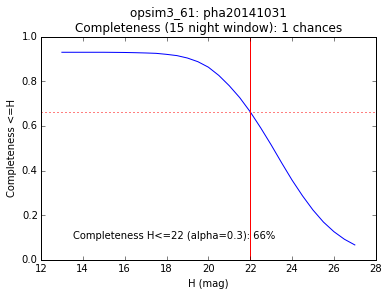

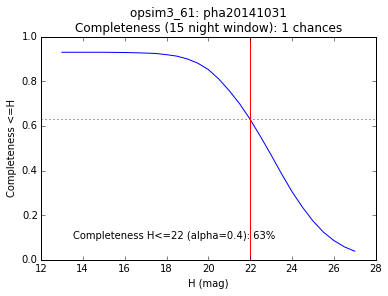

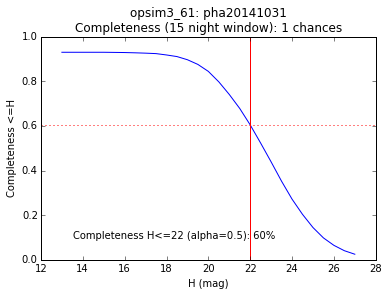

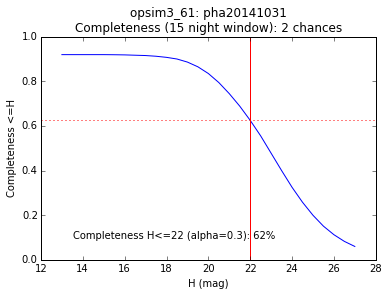

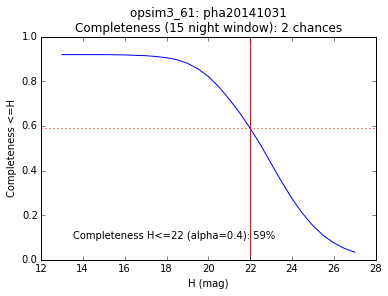

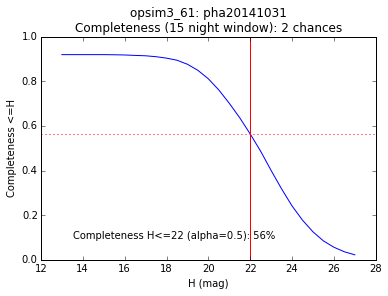

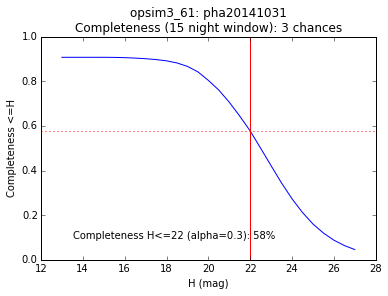

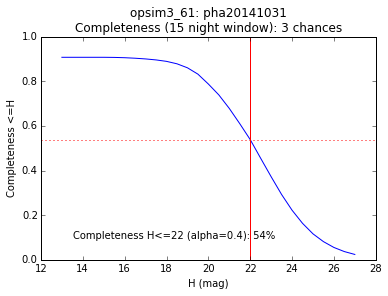

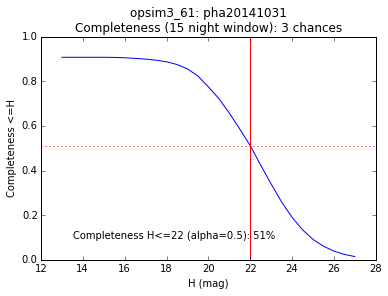

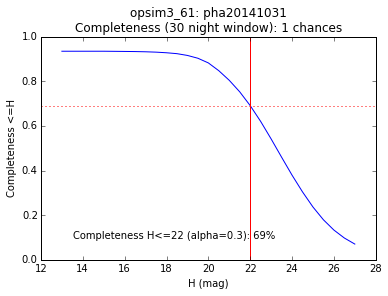

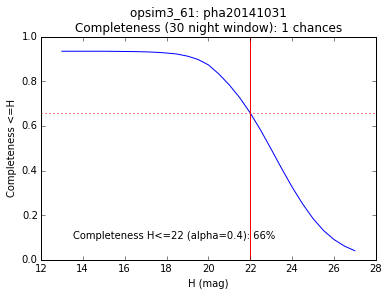

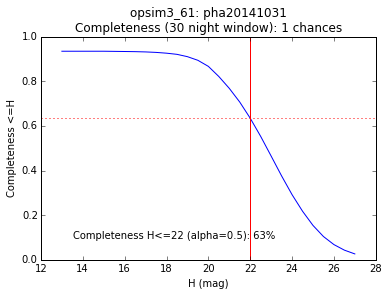

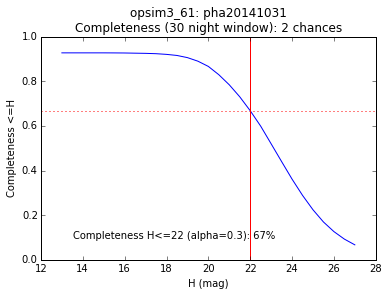

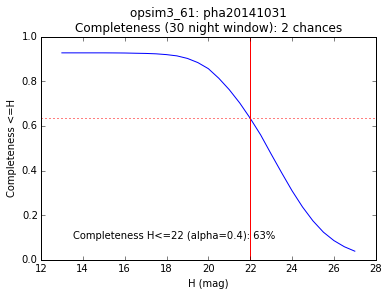

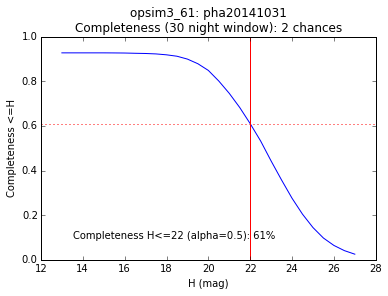

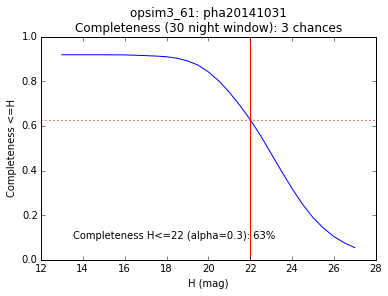

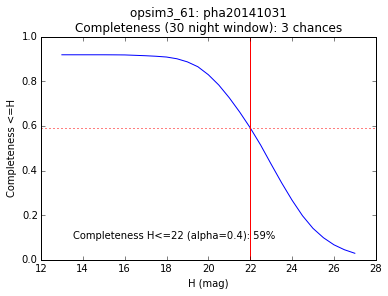

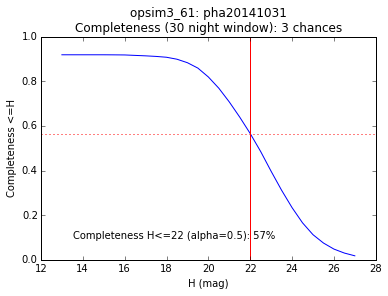

In [23]:
obs = opsim361obs
opsim = 'opsim3_61'

# Set up to run metrics over wider range of H.
Hrange = np.arange(13, 27.2, 0.5)
sNum = float(len(ssoids))

discoveries = np.zeros([len(ssoids), len(Hrange)], int)
discoveries30 = np.zeros([len(ssoids), len(Hrange)], int)
completeness = np.zeros([len(ssoids), len(Hrange)], int)

# Run Metrics.
for i, sso in enumerate(ssoids):
    ssoObs = obs[np.where(obs[ssoID] == sso)]
    orbit = orbits[np.where(orbits[ssoID_orbit] == sso)]
    discoveries[i] = DiscoveryMetric(ssoObs, Hrange=Hrange, window=15)
    discoveries30[i] = DiscoveryMetric(ssoObs, Hrange=Hrange, window=30)

completeness = Completeness(discoveries, Hrange, sNum)
completeness30 = Completeness(discoveries30, Hrange, sNum)

completeness_2 = Completeness(discoveries, Hrange, sNum, requiredChances=2)
completeness30_2 = Completeness(discoveries30, Hrange, sNum, requiredChances=2)

completeness_3 = Completeness(discoveries, Hrange, sNum, requiredChances=3)
completeness30_3 = Completeness(discoveries30, Hrange, sNum, requiredChances=3)

for i, c in enumerate([completeness, completeness_2, completeness_3]):
    for alpha in [0.3, 0.4, 0.5]:
        compH = integrateH(c, Hrange, Hindex=alpha)
        fignum = metricVsH(compH, Hrange, None)
        plt.ylabel('Completeness <=H')
        plt.title('%s: %s\n%s' %(opsim, outroot, 'Completeness (15 night window): %d chances' %(i+1)))
        #completeness at H<=22
        Hidx = np.where(Hrange==22.0)[0]
        comp22 = compH[Hidx]
        plt.axhline(comp22, color='r', linestyle=':')
        plt.axvline(22, color='r')
        plt.figtext(0.2, 0.2, 'Completeness H<=22 (alpha=%.1f): %.0f%s' %(alpha, comp22*100, '%'))
        print "Completeness at H<=22 with alpha=%.1f = %.1f%s (15 night window), requiring %d chances"  %(alpha, 
                                                                                            comp22*100, 
                                                                                            '%', i+1)

for i, c in enumerate([completeness30, completeness30_2, completeness30_3]):
    for alpha in [0.3, 0.4, 0.5]:
        compH = integrateH(c, Hrange, Hindex=alpha)
        fignum = metricVsH(compH, Hrange, None)
        plt.ylabel('Completeness <=H')
        plt.title('%s: %s\n%s' %(opsim, outroot, 'Completeness (30 night window): %d chances' %(i+1)))
        #completeness at H<=22
        Hidx = np.where(Hrange==22.0)[0]
        comp22 = compH[Hidx]
        plt.axhline(comp22, color='r', linestyle=':')
        plt.axvline(22, color='r')
        plt.figtext(0.2, 0.2, 'Completeness H<=22 (alpha=%.1f): %.0f%s' %(alpha, comp22*100, '%'))
        print "Completeness at H<=22 with alpha=%.1f = %.1f%s (30 night window), requiring %d chances"  %(alpha, 
                                                                                            comp22*100, 
                                                                                            '%', i+1)